In [1]:
# 1. Imports and Data Loading
import os
import pandas as pd
from datasets import Dataset
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer

# Set working directory
os.chdir("/Users/talhaahmed/Desktop/Thesis/Thesis Data")

In [11]:
# Load and clean data
df = pd.read_csv("vader_labeled_comments_full.csv")
df = df.dropna(subset=['comment', 'vader_sentiment'])
df = df[['comment', 'vader_sentiment']]

# Map sentiment to numeric labels
label_map = {'negative': 0, 'neutral': 1, 'positive': 2}
df['label'] = df['vader_sentiment'].map(label_map).astype(int)

In [13]:
print(df.columns)

Index(['comment', 'vader_sentiment', 'label'], dtype='object')


In [15]:
df.head()

,comment,vader_sentiment,label
0,Great n amazing movie..As a south east asia pe...,positive,2
1,This looks so much better!!!!! 🎉,positive,2
2,I have never wanted to see a movie more than this,neutral,1
3,I just can't wait to finally see it! Johnny's ...,positive,2
4,Elements don’t have body’s and don’t wear clot...,neutral,1


In [17]:
# 2. Train/Validation/Test Split (70/15/15)
train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42, stratify=df['label'])
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df['label'])

train_ds = Dataset.from_pandas(train_df.reset_index(drop=True))
val_ds = Dataset.from_pandas(val_df.reset_index(drop=True))
test_ds = Dataset.from_pandas(test_df.reset_index(drop=True))


In [19]:
# 3. Tokenizer and Preprocessing
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

def tokenize(example):
    tokens = tokenizer(example['comment'], truncation=True, padding="max_length", max_length=256)
    tokens['label'] = int(example['label'])
    return tokens

train_ds = train_ds.map(tokenize)
val_ds = val_ds.map(tokenize)
test_ds = test_ds.map(tokenize)

train_ds.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
val_ds.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
test_ds.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

Map:   0%|          | 0/55993 [00:00<?, ? examples/s]

Map:   0%|          | 0/11999 [00:00<?, ? examples/s]

Map:   0%|          | 0/11999 [00:00<?, ? examples/s]

In [21]:
# 4. Model Initialization
from transformers import BertForSequenceClassification

def model_init():
    return BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3)

# 5. Metrics
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

def compute_metrics(pred):
    preds = np.argmax(pred.predictions, axis=1)
    labels = pred.label_ids
    return {
        'accuracy': accuracy_score(labels, preds),
        'f1': f1_score(labels, preds, average='weighted'),
        'precision': precision_score(labels, preds, average='weighted'),
        'recall': recall_score(labels, preds, average='weighted')
    }

In [25]:
# 6. Base TrainingArguments for Optuna
from transformers import TrainingArguments, Trainer, EarlyStoppingCallback, DataCollatorWithPadding

base_training_args = TrainingArguments(
    output_dir="./bert_classification_model",
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_dir="./logs",
    report_to="none",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    seed=42
)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [27]:
# 7. Optuna Hyperparameter Search
import optuna

def model_hp_space(trial):
    return {
        "learning_rate": trial.suggest_float("learning_rate", 1e-5, 5e-5, log=True),
        "per_device_train_batch_size": trial.suggest_categorical("per_device_train_batch_size", [8, 16]),
        "num_train_epochs": trial.suggest_int("num_train_epochs", 3, 5),
        "weight_decay": trial.suggest_float("weight_decay", 0.0, 0.1),
    }

trainer = Trainer(
    model_init=model_init,
    args=base_training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

best_run = trainer.hyperparameter_search(
    direction="maximize",
    hp_space=model_hp_space,
    n_trials=10,
    backend="optuna"
)

print("✅ Best Hyperparameters Found:")
print(best_run.hyperparameters)

# Save best hyperparameters
import json
with open("best_hyperparameters.json", "w") as f:
    json.dump(best_run.hyperparameters, f, indent=2)

/var/folders/l9/8hmxymj146lc9m7tzd_r6lbm0000gn/T/ipykernel_57053/2850111560.py:12: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2025-06-15 17:55:16,038] A new study created in memory with name: no-name-7452c5ea-ce1c-482b-ba04-1a26f7fd41f1
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/anaconda3/lib/python3.12/site-packages/torch/utils/data/d

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.348500,0.372630,0.890074,0.889363,0.890789,0.890074
2,0.251800,0.310134,0.906576,0.906579,0.906657,0.906576
3,0.185700,0.362479,0.908409,0.908480,0.909108,0.908409
4,0.146600,0.398521,0.908992,0.909111,0.909340,0.908992
5,0.111000,0.488552,0.904575,0.904583,0.904599,0.904575


/opt/anaconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/opt/anaconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/opt/anaconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/opt/anaconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
[I 2025-06-16 15:30:58,763] Trial 0 finished with value: 3.618332360265191 and parameters: {

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.306800,0.301467,0.896991,0.896953,0.898683,0.896991
2,0.224900,0.255568,0.909076,0.908965,0.910348,0.909076
3,0.162000,0.302703,0.908326,0.908261,0.909270,0.908326
4,0.115500,0.367895,0.906159,0.906042,0.906002,0.906159


/opt/anaconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/opt/anaconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/opt/anaconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
[I 2025-06-17 11:01:52,507] Trial 1 finished with value: 3.6243617209201164 and parameters: {'learning_rate': 3.51946186244176e-05, 'per_device_train_batch_size': 16, 'num_train_epochs': 4, 'weight_decay': 0.057174363992246416}. Best is trial 1 with value: 3.6243617209201164.
Some weights of BertForSequenceClassificat

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.307000,0.293955,0.900075,0.900240,0.901422,0.900075
2,0.227900,0.258233,0.907826,0.907747,0.911683,0.907826
3,0.170400,0.297664,0.910576,0.910488,0.910932,0.910576
4,0.120500,0.347226,0.906326,0.906159,0.906172,0.906326


/opt/anaconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/opt/anaconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/opt/anaconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
[I 2025-06-17 21:08:06,462] Trial 2 finished with value: 3.624981489609748 and parameters: {'learning_rate': 2.7997696516189593e-05, 'per_device_train_batch_size': 16, 'num_train_epochs': 4, 'weight_decay': 0.032881125137832125}. Best is trial 2 with value: 3.624981489609748.
Some weights of BertForSequenceClassificat

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.326500,0.315470,0.889407,0.889278,0.890475,0.889407
2,0.256500,0.278867,0.901575,0.901435,0.902650,0.901575
3,0.204000,0.299404,0.907159,0.907009,0.908607,0.907159
4,0.181300,0.320555,0.905659,0.905580,0.905894,0.905659


/opt/anaconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/opt/anaconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/opt/anaconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
[I 2025-06-18 15:00:39,206] Trial 3 finished with value: 3.622791619648069 and parameters: {'learning_rate': 1.0617229161826863e-05, 'per_device_train_batch_size': 16, 'num_train_epochs': 4, 'weight_decay': 0.00969681185117426}. Best is trial 2 with value: 3.624981489609748.
Some weights of BertForSequenceClassificati

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.343500,0.347149,0.892241,0.891789,0.892368,0.892241
2,0.262000,0.317222,0.904075,0.904040,0.904349,0.904075
3,0.175100,0.355194,0.905409,0.905470,0.905806,0.905409


/opt/anaconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/opt/anaconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
[I 2025-06-19 08:33:20,979] Trial 4 finished with value: 3.6220937572553797 and parameters: {'learning_rate': 1.3036264173236746e-05, 'per_device_train_batch_size': 8, 'num_train_epochs': 3, 'weight_decay': 0.04808531546486168}. Best is trial 2 with value: 3.624981489609748.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for pred

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.346700,0.362077,0.891658,0.890992,0.892427,0.891658


[I 2025-06-19 11:49:01,743] Trial 5 pruned. 
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/anaconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.317400,0.306379,0.893908,0.893860,0.894877,0.893908


[I 2025-06-19 15:11:34,408] Trial 6 pruned. 
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/anaconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.314200,0.303448,0.893574,0.893532,0.893942,0.893574


[I 2025-06-19 17:15:44,993] Trial 7 pruned. 
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/anaconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.300900,0.323606,0.899742,0.899847,0.901158,0.899742
2,0.225700,0.258960,0.908909,0.908914,0.911356,0.908909
3,0.166200,0.300382,0.909826,0.909739,0.910449,0.909826
4,0.122100,0.354085,0.907076,0.906867,0.906937,0.907076


/opt/anaconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/opt/anaconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/opt/anaconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
[I 2025-06-20 13:20:44,042] Trial 8 finished with value: 3.627955047235228 and parameters: {'learning_rate': 3.3499209710417054e-05, 'per_device_train_batch_size': 16, 'num_train_epochs': 4, 'weight_decay': 0.015713050589290022}. Best is trial 8 with value: 3.627955047235228.
Some weights of BertForSequenceClassificat

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.308000,0.327326,0.900408,0.900398,0.902300,0.900408
2,0.227400,0.287066,0.906242,0.906109,0.908519,0.906242
3,0.171800,0.315000,0.907409,0.907175,0.908560,0.907409


/opt/anaconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/opt/anaconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
[I 2025-06-21 05:42:54,581] Trial 9 pruned. 


✅ Best Hyperparameters Found:
{'learning_rate': 3.3499209710417054e-05, 'per_device_train_batch_size': 16, 'num_train_epochs': 4, 'weight_decay': 0.015713050589290022}


In [29]:
# time to fine-tune the model on the best identified parameters 
from datasets import concatenate_datasets

final_train_ds = concatenate_datasets([train_ds, val_ds])

In [33]:
from transformers import TrainingArguments

final_training_args = TrainingArguments(
    output_dir="./final_bert_model",
    per_device_train_batch_size=16,
    learning_rate=3.3499209710417054e-05,
    num_train_epochs=4,
    weight_decay=0.015713050589290022,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    logging_dir="./final_logs",
    report_to="none",
    seed=42
)

In [35]:
final_trainer = Trainer(
    model_init=model_init,
    args=final_training_args,
    train_dataset=final_train_ds,
    eval_dataset=test_ds,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

final_trainer.train()
final_trainer.save_model("./final_bert_model")

/var/folders/l9/8hmxymj146lc9m7tzd_r6lbm0000gn/T/ipykernel_57053/357119099.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  final_trainer = Trainer(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/anaconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device 

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.300500,0.273366,0.901408,0.901636,0.904518,0.901408
2,0.215100,0.263076,0.904992,0.905055,0.906120,0.904992
3,0.172100,0.293011,0.909076,0.909470,0.910766,0.909076
4,0.105500,0.352787,0.911243,0.911221,0.911210,0.911243


/opt/anaconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/opt/anaconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/opt/anaconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


In [6]:
import os
import pandas as pd
import numpy as np
from datasets import Dataset
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments, DataCollatorWithPadding
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [8]:
# Set working directory
os.chdir("/Users/talhaahmed/Desktop/Thesis/Thesis Data")

# Load and preprocess
df = pd.read_csv("vader_labeled_comments_full.csv")
df = df.dropna(subset=['comment', 'vader_sentiment'])
df['label'] = df['vader_sentiment'].map({'negative': 0, 'neutral': 1, 'positive': 2}).astype(int)

# Redo split (same seed = same split)
_, temp_df = train_test_split(df, test_size=0.3, random_state=42, stratify=df['label'])
_, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df['label'])

test_ds = Dataset.from_pandas(test_df.reset_index(drop=True))

In [10]:
model_path = "./final_bert_model"

tokenizer = BertTokenizer.from_pretrained(model_path)
model = BertForSequenceClassification.from_pretrained(model_path)

In [12]:
def tokenize(example):
    tokens = tokenizer(example['comment'], truncation=True, padding="max_length", max_length=256)
    tokens['label'] = int(example['label'])
    return tokens

test_ds = test_ds.map(tokenize)
test_ds.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

Map:   0%|          | 0/11999 [00:00<?, ? examples/s]

In [14]:
training_args = TrainingArguments(
    output_dir="./final_bert_model",
    per_device_eval_batch_size=16,
    report_to="none"
)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

final_trainer = Trainer(
    model=model,
    args=training_args,
    tokenizer=tokenizer,
    data_collator=data_collator
)

/var/folders/l9/8hmxymj146lc9m7tzd_r6lbm0000gn/T/ipykernel_15060/2845138053.py:9: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  final_trainer = Trainer(


/opt/anaconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


📊 Classification Report:
              precision    recall  f1-score   support

    negative     0.8851    0.8825    0.8838      3003
     neutral     0.9178    0.9126    0.9152      3525
    positive     0.9213    0.9262    0.9237      5471

    accuracy                         0.9112     11999
   macro avg     0.9081    0.9071    0.9076     11999
weighted avg     0.9112    0.9112    0.9112     11999



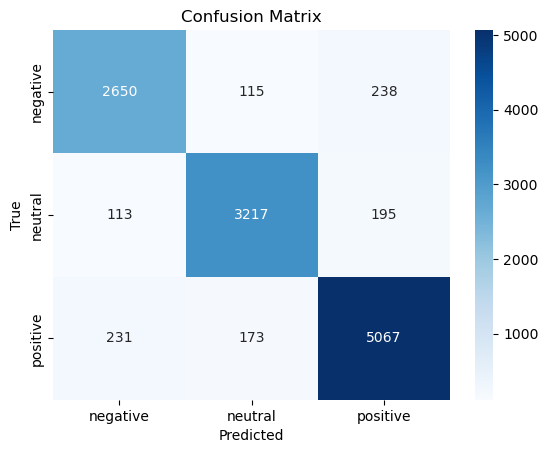

In [16]:
# Predict
predictions_output = final_trainer.predict(test_ds)
y_true = predictions_output.label_ids
y_pred = np.argmax(predictions_output.predictions, axis=1)

# Classification Report
print("📊 Classification Report:")
print(classification_report(y_true, y_pred, target_names=["negative", "neutral", "positive"], digits=4))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["negative", "neutral", "positive"], yticklabels=["negative", "neutral", "positive"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [18]:
##### checking the fine-tuned model's performance on a sample of 30 comments 
# Load full labeled dataset (if not already loaded)
df = pd.read_csv("vader_labeled_comments_full.csv")
df = df.dropna(subset=['comment', 'vader_sentiment'])

# Sample 30 comments for comparison
sample_df = df.sample(30, random_state=42).reset_index(drop=True)

# Optional: Map VADER label to integer for later comparison
label_map = {'negative': 0, 'neutral': 1, 'positive': 2}
id2label = {v: k for k, v in label_map.items()}
sample_df['label'] = sample_df['vader_sentiment'].map(label_map)

In [22]:
sample_df.head()

,Unnamed: 0,title,comment_date,author,comment,likes,video_id,release_date,neg,neu,pos,compound,vader_sentiment,label
0,1430112,Black Adam,2022-06-08,@levixenos8711,Marvel kids who had no idea about it crying in...,0,X0tOpBuYasI,2022-10-20,0.375,0.463,0.162,-0.5673,negative,0
1,1495254,Cocaine Bear,2022-12-02,@keegandecker4080,IRL the bear died almost immediately of an OD,0,DuWEEKeJLMI,2023-02-23,0.310,0.690,0.000,-0.5574,negative,0
2,1363019,Elvis,2022-03-22,@TonyDanza4Lyfe,I thought this dude was extremely miscast as t...,0,wBDLRvjHVOY,2022-06-23,0.000,0.784,0.216,0.5927,positive,2
3,695841,"New Mutants, The",2020-01-11,@samuelfrancis1816,"This mutant genes fault is the celestials, the...",1,W_vJhUAOFpI,2020-08-26,0.172,0.828,0.000,-0.4019,negative,0
4,495194,Zombieland: Double Tap,2019-07-25,@prod.extema.da.sickomane,So I am very happy that the second part finall...,0,ZlW9yhUKlkQ,2019-10-24,0.000,0.778,0.222,0.6115,positive,2


In [24]:
from datasets import Dataset

# Convert to HF dataset
sample_ds = Dataset.from_pandas(sample_df)

# Tokenize
def tokenize(example):
    return tokenizer(example['comment'], truncation=True, padding="max_length", max_length=256)

tokenized_sample = sample_ds.map(tokenize)
tokenized_sample.set_format(type="torch", columns=["input_ids", "attention_mask"])

Map:   0%|          | 0/30 [00:00<?, ? examples/s]

In [26]:
# Run predictions
sample_preds = final_trainer.predict(tokenized_sample)

# Add predicted labels to the original sample_df
sample_df['predicted_label'] = np.argmax(sample_preds.predictions, axis=1)
sample_df['predicted_label_str'] = sample_df['predicted_label'].map(id2label)

/opt/anaconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


In [28]:
# View results
sample_df[['comment', 'vader_sentiment', 'predicted_label_str']]

,comment,vader_sentiment,predicted_label_str
0,Marvel kids who had no idea about it crying in...,negative,negative
1,IRL the bear died almost immediately of an OD,negative,negative
2,I thought this dude was extremely miscast as t...,positive,positive
3,"This mutant genes fault is the celestials, the...",negative,negative
4,So I am very happy that the second part finall...,positive,positive
5,Where's Spenser and Bethany,neutral,neutral
6,"How tf was he bothering him, boi was having fun",positive,positive
7,Hyper-fixation reawakened🗣🗣🗣🗣🗣🗣🗣🗣🗣🗣🗣🗣🗣🗣🗣🗣🗣🗣🗣🗣,neutral,neutral
8,Hi I'm Tom Holland and I'm a sheep that weren'...,negative,negative
9,Yesss it’s givinnn 😍😍,positive,positive


In [34]:
# let's check the performance of the fine tuned model on 100 comments and see where it disagrees with vader 
# Sample 100 comments
sample_df = df.sample(100, random_state=42).reset_index(drop=True)

# Convert to HF dataset and tokenize
sample_ds = Dataset.from_pandas(sample_df)

def tokenize(example):
    return tokenizer(example['comment'], truncation=True, padding="max_length", max_length=256)

tokenized_sample = sample_ds.map(tokenize)
tokenized_sample.set_format(type="torch", columns=["input_ids", "attention_mask"])

# Predict with fine-tuned BERT model
sample_preds = final_trainer.predict(tokenized_sample)
sample_df['predicted_label'] = np.argmax(sample_preds.predictions, axis=1)
sample_df['predicted_label_str'] = sample_df['predicted_label'].map(id2label)

# to observe the full comment
pd.set_option("display.max_colwidth", None)

# Filter disagreements between BERT and VADER
disagreements_df = sample_df[sample_df['vader_sentiment'] != sample_df['predicted_label_str']].reset_index(drop=True)

# View disagreements
disagreements_df[['comment', 'vader_sentiment', 'predicted_label_str']]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

/opt/anaconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


,comment,vader_sentiment,predicted_label_str
0,"There's no way I can watch Tom Hanks and feel like I'm watching a grumpy old man. Sorry, but he can't do ""grumpy.""",neutral,negative
1,Hate🤮,negative,positive
2,I absolutely can't wait for doctor strange 2 to come out 😁😁😁,positive,negative
3,"Picking a random song from the 60s, 70s or 80s and throwing on a trailer doesn't make the freaking film good people. Stop falling for this crap.",neutral,positive
4,"I saw, James Wan, I'm in! 🔥👏",negative,positive


In [32]:
sample_df

,Unnamed: 0,title,comment_date,author,comment,likes,video_id,release_date,neg,neu,pos,compound,vader_sentiment,predicted_label,predicted_label_str
0,1430112,Black Adam,2022-06-08,@levixenos8711,Marvel kids who had no idea about it crying in...,0,X0tOpBuYasI,2022-10-20,0.375,0.463,0.162,-0.5673,negative,0,negative
1,1495254,Cocaine Bear,2022-12-02,@keegandecker4080,IRL the bear died almost immediately of an OD,0,DuWEEKeJLMI,2023-02-23,0.310,0.690,0.000,-0.5574,negative,0,negative
2,1363019,Elvis,2022-03-22,@TonyDanza4Lyfe,I thought this dude was extremely miscast as t...,0,wBDLRvjHVOY,2022-06-23,0.000,0.784,0.216,0.5927,positive,2,positive
3,695841,"New Mutants, The",2020-01-11,@samuelfrancis1816,"This mutant genes fault is the celestials, the...",1,W_vJhUAOFpI,2020-08-26,0.172,0.828,0.000,-0.4019,negative,0,negative
4,495194,Zombieland: Double Tap,2019-07-25,@prod.extema.da.sickomane,So I am very happy that the second part finall...,0,ZlW9yhUKlkQ,2019-10-24,0.000,0.778,0.222,0.6115,positive,2,positive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,1561584,Evil Dead Rise,2023-01-26,@naomigray21,This looks so good,0,smTK_AeAPHs,2023-04-20,0.000,0.445,0.555,0.5777,positive,2,positive
96,1830920,Night Swim,2023-10-12,@aechiyo9008,"I saw, James Wan, I'm in! 🔥👏",0,pcSNqteCEtE,2024-01-04,0.252,0.748,0.000,-0.4003,negative,2,positive
97,2550408,Fast X,2023-02-14,@biggestthreattoyourexistence,Oh thank goodness the original cast. The Rock ...,0,32RAq6JzY-w,2023-05-18,0.169,0.393,0.438,0.5859,positive,2,positive
98,2476846,Black Panther: Wakanda Forever,2022-10-09,@TheRichard73,"I’m disappointed, really wanted Killmonger",0,_Z3QKkl1WyM,2022-11-10,0.437,0.563,0.000,-0.4767,negative,0,negative


In [36]:
import torch
from torch.nn.functional import softmax
import pandas as pd
from datasets import Dataset

# Sample 100 comments
sample_df = df.sample(100, random_state=42).reset_index(drop=True)

# Convert to HF dataset and tokenize
sample_ds = Dataset.from_pandas(sample_df)

def tokenize(example):
    return tokenizer(example['comment'], truncation=True, padding="max_length", max_length=256)

tokenized_sample = sample_ds.map(tokenize)
tokenized_sample.set_format(type="torch", columns=["input_ids", "attention_mask"])

# Predict with fine-tuned BERT model
sample_preds = final_trainer.predict(tokenized_sample)

# Predicted class
sample_df['predicted_label'] = np.argmax(sample_preds.predictions, axis=1)
sample_df['predicted_label_str'] = sample_df['predicted_label'].map(id2label)

# Get softmax confidence scores
probs = softmax(torch.tensor(sample_preds.predictions), dim=1)
sample_df['bert_confidence'] = torch.max(probs, dim=1).values.numpy()

# Show full comments
pd.set_option("display.max_colwidth", None)

# Filter and show disagreements with confidence
disagreements_df = sample_df[sample_df['vader_sentiment'] != sample_df['predicted_label_str']].reset_index(drop=True)
disagreements_df[['comment', 'vader_sentiment', 'predicted_label_str', 'bert_confidence']]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

/opt/anaconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


,comment,vader_sentiment,predicted_label_str,bert_confidence
0,"There's no way I can watch Tom Hanks and feel like I'm watching a grumpy old man. Sorry, but he can't do ""grumpy.""",neutral,negative,0.520862
1,Hate🤮,negative,positive,0.649006
2,I absolutely can't wait for doctor strange 2 to come out 😁😁😁,positive,negative,0.607378
3,"Picking a random song from the 60s, 70s or 80s and throwing on a trailer doesn't make the freaking film good people. Stop falling for this crap.",neutral,positive,0.762711
4,"I saw, James Wan, I'm in! 🔥👏",negative,positive,0.745483


In [38]:
# time to label all the comments with the fine tuned model 
import pandas as pd
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from torch.nn.functional import softmax
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

# --- Load Fine-Tuned Model and Tokenizer ---
model_path = "./final_bert_model"
tokenizer = BertTokenizer.from_pretrained(model_path)
model = BertForSequenceClassification.from_pretrained(model_path)
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# --- Label Mapping ---
id2label = {0: "negative", 1: "neutral", 2: "positive"}

# --- Define Batch Prediction Function ---
def predict_batch(texts, batch_size=64):
    """Tokenize text and predict sentiment in batches"""
    encodings = tokenizer(texts, truncation=True, padding=True, max_length=256, return_tensors='pt')
    dataset = TensorDataset(encodings['input_ids'], encodings['attention_mask'])
    loader = DataLoader(dataset, batch_size=batch_size)

    preds, confidences = [], []

    with torch.no_grad():
        for batch in loader:
            input_ids, attention_mask = [b.to(device) for b in batch]
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            probs = softmax(logits, dim=1)
            batch_preds = torch.argmax(probs, dim=1).cpu().numpy()
            batch_confs = torch.max(probs, dim=1).values.cpu().numpy()

            preds.extend(batch_preds)
            confidences.extend(batch_confs)

    return preds, confidences

# --- Set Up Chunked Processing Parameters ---
chunksize = 100_000  # Adjust based on your machine's memory
input_file = "super_final_comments.csv"
output_file = "super_final_comments_labeled.csv"

# --- Read CSV in Chunks and Process ---
reader = pd.read_csv(input_file, chunksize=chunksize)
total_chunks = sum(1 for _ in pd.read_csv(input_file, chunksize=chunksize))  # Get number of chunks for tqdm

for i, chunk in enumerate(tqdm(pd.read_csv(input_file, chunksize=chunksize), total=total_chunks, desc="Labeling Chunks")):
    print(f"\n🔄 Processing chunk {i + 1}")

    # Drop missing comments
    chunk = chunk.dropna(subset=["comment"])

    # Extract comment texts
    texts = chunk["comment"].astype(str).tolist()

    # Predict sentiment and confidence
    preds, confs = predict_batch(texts)

    # Add predictions to chunk
    chunk["bert_sentiment"] = [id2label[p] for p in preds]
    chunk["bert_confidence"] = confs

    # Save results to CSV incrementally
    if i == 0:
        chunk.to_csv(output_file, index=False)
    else:
        chunk.to_csv(output_file, mode="a", index=False, header=False)

Labeling Chunks:   0%|                                   | 0/27 [00:00<?, ?it/s]


🔄 Processing chunk 1


/var/folders/l9/8hmxymj146lc9m7tzd_r6lbm0000gn/T/ipykernel_15060/1958467566.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk["bert_sentiment"] = [id2label[p] for p in preds]
/var/folders/l9/8hmxymj146lc9m7tzd_r6lbm0000gn/T/ipykernel_15060/1958467566.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk["bert_confidence"] = confs
Labeling Chunks:   4%|▋                  | 1/27 [2:56:18<76:23:51, 10578.12s/it]


🔄 Processing chunk 2


/var/folders/l9/8hmxymj146lc9m7tzd_r6lbm0000gn/T/ipykernel_15060/1958467566.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk["bert_sentiment"] = [id2label[p] for p in preds]
/var/folders/l9/8hmxymj146lc9m7tzd_r6lbm0000gn/T/ipykernel_15060/1958467566.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk["bert_confidence"] = confs
Labeling Chunks:   7%|█▍                  | 2/27 [5:03:13<61:21:17, 8835.09s/it]


🔄 Processing chunk 3


/var/folders/l9/8hmxymj146lc9m7tzd_r6lbm0000gn/T/ipykernel_15060/1958467566.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk["bert_sentiment"] = [id2label[p] for p in preds]
/var/folders/l9/8hmxymj146lc9m7tzd_r6lbm0000gn/T/ipykernel_15060/1958467566.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk["bert_confidence"] = confs
Labeling Chunks:  11%|██▏                 | 3/27 [7:22:40<57:28:38, 8621.61s/it]


🔄 Processing chunk 4


Labeling Chunks:  15%|██▌              | 4/27 [20:18:59<150:49:14, 23606.70s/it]


🔄 Processing chunk 5


Labeling Chunks:  19%|███▏             | 5/27 [22:31:29<109:45:36, 17960.75s/it]


🔄 Processing chunk 6


Labeling Chunks:  22%|████              | 6/27 [24:52:17<85:54:18, 14726.60s/it]


🔄 Processing chunk 7


Labeling Chunks:  26%|████▋             | 7/27 [28:28:16<78:36:10, 14148.53s/it]


🔄 Processing chunk 8


Labeling Chunks:  30%|█████▎            | 8/27 [31:08:30<67:03:16, 12705.10s/it]


🔄 Processing chunk 9


Labeling Chunks:  33%|██████            | 9/27 [36:06:51<71:38:49, 14329.44s/it]


🔄 Processing chunk 10


Labeling Chunks:  37%|█████▉          | 10/27 [47:03:00<104:10:10, 22059.44s/it]


🔄 Processing chunk 11


Labeling Chunks:  41%|██████▉          | 11/27 [50:04:39<82:51:41, 18643.85s/it]


🔄 Processing chunk 12


Labeling Chunks:  44%|███████▌         | 12/27 [52:20:45<64:24:04, 15456.33s/it]


🔄 Processing chunk 13


Labeling Chunks:  48%|████████▏        | 13/27 [55:03:44<53:25:12, 13736.60s/it]


🔄 Processing chunk 14


Labeling Chunks:  52%|████████▊        | 14/27 [70:22:16<94:44:02, 26234.05s/it]


🔄 Processing chunk 15


Labeling Chunks:  56%|█████████▍       | 15/27 [72:40:28<69:25:05, 20825.48s/it]


🔄 Processing chunk 16


Labeling Chunks:  59%|██████████       | 16/27 [76:11:30<56:07:34, 18368.56s/it]


🔄 Processing chunk 17


Labeling Chunks:  63%|██████████▋      | 17/27 [79:01:47<44:12:52, 15917.28s/it]


🔄 Processing chunk 18


Labeling Chunks:  67%|███████████▎     | 18/27 [91:58:52<62:51:41, 25144.61s/it]


🔄 Processing chunk 19


Labeling Chunks:  70%|██████████▌    | 19/27 [117:28:48<100:21:41, 45162.68s/it]


🔄 Processing chunk 20


Labeling Chunks:  74%|███████████▊    | 20/27 [119:51:55<66:27:48, 34181.25s/it]


🔄 Processing chunk 21


/var/folders/l9/8hmxymj146lc9m7tzd_r6lbm0000gn/T/ipykernel_15060/1958467566.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk["bert_sentiment"] = [id2label[p] for p in preds]
/var/folders/l9/8hmxymj146lc9m7tzd_r6lbm0000gn/T/ipykernel_15060/1958467566.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk["bert_confidence"] = confs
Labeling Chunks:  78%|████████████▍   | 21/27 [122:41:28<44:57:29, 26974.95s/it]


🔄 Processing chunk 22


/var/folders/l9/8hmxymj146lc9m7tzd_r6lbm0000gn/T/ipykernel_15060/1958467566.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk["bert_sentiment"] = [id2label[p] for p in preds]
/var/folders/l9/8hmxymj146lc9m7tzd_r6lbm0000gn/T/ipykernel_15060/1958467566.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk["bert_confidence"] = confs
Labeling Chunks:  81%|█████████████   | 22/27 [126:11:11<31:27:57, 22655.48s/it]


🔄 Processing chunk 23


/var/folders/l9/8hmxymj146lc9m7tzd_r6lbm0000gn/T/ipykernel_15060/1958467566.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk["bert_sentiment"] = [id2label[p] for p in preds]
/var/folders/l9/8hmxymj146lc9m7tzd_r6lbm0000gn/T/ipykernel_15060/1958467566.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk["bert_confidence"] = confs
Labeling Chunks:  85%|█████████████▋  | 23/27 [130:32:12<22:50:26, 20556.63s/it]


🔄 Processing chunk 24


/var/folders/l9/8hmxymj146lc9m7tzd_r6lbm0000gn/T/ipykernel_15060/1958467566.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk["bert_sentiment"] = [id2label[p] for p in preds]
/var/folders/l9/8hmxymj146lc9m7tzd_r6lbm0000gn/T/ipykernel_15060/1958467566.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk["bert_confidence"] = confs
Labeling Chunks:  89%|██████████████▏ | 24/27 [143:10:12<23:21:44, 28035.00s/it]


🔄 Processing chunk 25


/var/folders/l9/8hmxymj146lc9m7tzd_r6lbm0000gn/T/ipykernel_15060/1958467566.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk["bert_sentiment"] = [id2label[p] for p in preds]
/var/folders/l9/8hmxymj146lc9m7tzd_r6lbm0000gn/T/ipykernel_15060/1958467566.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk["bert_confidence"] = confs
Labeling Chunks:  93%|██████████████▊ | 25/27 [147:05:15<13:15:10, 23855.04s/it]


🔄 Processing chunk 26


/var/folders/l9/8hmxymj146lc9m7tzd_r6lbm0000gn/T/ipykernel_15060/1958467566.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk["bert_sentiment"] = [id2label[p] for p in preds]
/var/folders/l9/8hmxymj146lc9m7tzd_r6lbm0000gn/T/ipykernel_15060/1958467566.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk["bert_confidence"] = confs
Labeling Chunks:  96%|████████████████▎| 26/27 [149:23:42<5:19:50, 19190.19s/it]


🔄 Processing chunk 27


Labeling Chunks: 100%|███████████████████| 27/27 [149:44:08<00:00, 19964.77s/it]


In [40]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# ...after generating y_true and y_pred
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=["Negative", "Neutral", "Positive"], 
            yticklabels=["Negative", "Neutral", "Positive"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix for BERT Sentiment Classifier")
plt.tight_layout()

# Save high-res image
plt.savefig("confusion_matrix.png", dpi=300)     # for Word
plt.savefig("confusion_matrix.pdf")              # if you want vector quality (great for LaTeX)
plt.savefig("confusion_matrix.svg")              # optional: for scalable vector in Word or Illustrator
plt.close()